In [65]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [66]:
import sys

In [67]:
sys.executable

'/Users/leevironty/koodi/kandi/venv/bin/python3'

In [149]:
from prophet.python import fbprophet
from prophet.python.fbprophet import models
from prophet.python.fbprophet import plot
from prophet.python.fbprophet import diagnostics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import os
from pathlib import Path
import numpy as np
import scipy
from copy import deepcopy
import tqdm

import metrics_refactored

from make_datasets import data, datasets, format_for_prophet, dataset_generator


In [146]:
datasets['A'].head()

,ds,temperature,fuel_price,cpi,unemployment_interpolated,y,temp_diff,fuel_diff,cpi_diff,IsHoliday,overfit
1,2010-02-12,32.856791,2.685976,170.819624,8.433678,1.516366e+06,-0.833241,-0.017864,0.097484,True,0.606013
2,2010-02-19,36.120051,2.657191,170.866465,8.413886,1.518252e+06,3.263260,-0.028786,0.046841,False,0.602750
3,2010-02-26,38.431706,2.678402,170.904866,8.394094,1.370861e+06,2.311655,0.021212,0.038401,False,0.508007
4,2010-03-05,42.054062,2.724567,170.943267,8.374303,1.468024e+06,3.622356,0.046165,0.038401,False,0.548960
5,2010-03-12,47.561955,2.761880,170.981667,8.354511,1.438255e+06,5.507893,0.037313,0.038401,False,0.542127


In [147]:
format_for_prophet(data[data['Store']==1]).head()

,index,Store,ds,temperature,fuel_price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Unemployment,IsHoliday,unemployment_interpolated,temp_diff,fuel_diff,cpi_diff,y,Type,Size,overfit
1,1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,...,8.106,True,8.06875,-3.80,-0.024,0.145812,1641957.44,A,151315,0.698929
2,2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,...,8.106,False,8.03150,1.42,-0.034,0.046973,1611968.17,A,151315,0.682368
3,3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,...,8.106,False,7.99425,6.70,0.047,0.030500,1409727.59,A,151315,0.560737
4,4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,...,8.106,False,7.95700,-0.13,0.064,0.030500,1554806.68,A,151315,0.624339
5,5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,...,8.106,False,7.91975,11.29,0.042,0.030500,1439541.59,A,151315,0.580911


In [82]:
def dataset_generator():  # Toimii
    out = []
    for l in 'ABC':
        out.append((f'aggregated_{l}', datasets[l]))
        for i in data[data['Type']==l]['Store'].drop_duplicates().sample(n=3):
            out.append((f'single_store_{i}_of_{l}', format_for_prophet(data[data['Store']==i])))
    return out

In [14]:
def sweep_samples(model, data, warmup=None, metrics = {'aic':aic, 'dic':dic, 'waic':waic}, points = 30):

    if warmup is None:
        warmup = model.mcmc_samples//2
    max_samples = model.mcmc_samples - warmup
    fit = model.fit(data, control=fit_kwargs, warmup=warmup)
    og_params = model.params.copy()

    res = pd.DataFrame(columns=metrics.keys())

    def sliced_params(s):
        stan_fit = fit.stan_backend.stan_fit
        ex = stan_fit.extract(permuted=False)[:, :, :-1]
        fn_split = pd.Series(stan_fit.flatnames).apply(lambda x: x.split('[')[0])
        var_names = fn_split.unique()
        params = {}
        for name in var_names:
            reshape_mask = fn_split == name
            reshape_dim = reshape_mask.sum()
            params[name] = ex[:s, :, (fn_split == name).values].reshape((s*4, reshape_dim), order='F')
            np.random.shuffle(params[name])
        return params

    
    for s in np.linspace(max_samples//points, max_samples, points).astype(int):
        row = pd.Series()
        row['samples'] = s
        fit.params = sliced_params(s)
        for metric_name, metric in metrics.items():
            row[metric_name] = metric(fit)
        res = res.append(row, ignore_index=True)
    return res
    

NameError: name 'aic' is not defined

In [661]:
warmup=500  # test cv sample sweep
data = datasets['A']
model = fbprophet.Prophet(mcmc_samples=6500, seasonality_mode='additive')
for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated', 'IsHoliday']:
    model.add_regressor(r)

if warmup is None:
    warmup = model.mcmc_samples//2
max_samples = model.mcmc_samples - warmup
fit = model.fit(data, control=fit_kwargs, warmup=warmup)
og_params = model.params.copy()

res = k_fold_loo_cv_sweepable(fit, 300, max_samples, k=10)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 0/10
Fitting 1/10
Fitting 2/10
Fitting 3/10
Fitting 4/10
Fitting 5/10
Fitting 6/10
Fitting 7/10
Fitting 8/10
Fitting 9/10
Calculating for 20/6000 samples
Calculating for 40/6000 samples
Calculating for 60/6000 samples
Calculating for 80/6000 samples
Calculating for 100/6000 samples
Calculating for 120/6000 samples
Calculating for 140/6000 samples
Calculating for 160/6000 samples
Calculating for 180/6000 samples
Calculating for 200/6000 samples
Calculating for 220/6000 samples
Calculating for 240/6000 samples
Calculating for 260/6000 samples
Calculating for 280/6000 samples
Calculating for 300/6000 samples
Calculating for 320/6000 samples
Calculating for 340/6000 samples
Calculating for 360/6000 samples
Calculating for 380/6000 samples
Calculating for 400/6000 samples
Calculating for 420/6000 samples
Calculating for 440/6000 samples
Calculating for 460/6000 samples
Calculating for 480/6000 samples
Calculating for 500/6000 samples
Calculating for 520/6000 samples
Calculating for 

<AxesSubplot:xlabel='samples'>

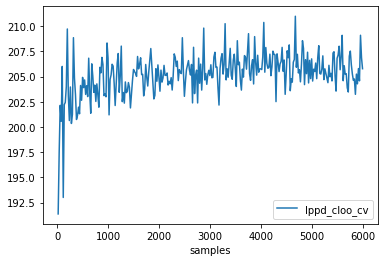

In [734]:
res.plot(x='samples', y='lppd_cloo_cv')

<AxesSubplot:xlabel='samples'>

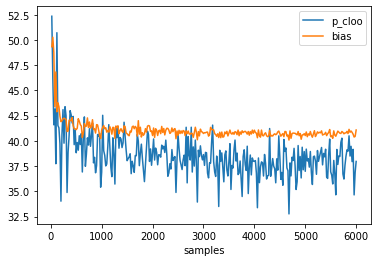

In [665]:
res[['samples', 'p_cloo', 'bias']].plot(x='samples')

In [667]:
res.to_csv('10-fold-loo.csv')

In [ ]:
standard_noise = np.random.normal()
def y_to_overfit(y):
    

In [83]:
def get_clean_models():
    samples = 1000
    # Initialize models
    m1 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
    m2 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
    m3 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive', seasonality_prior_scale=1)
    m4 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=20, seasonality_mode='additive', seasonality_prior_scale=1)
    m5 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=False, n_changepoints=1, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)

    for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated', 'IsHoliday']:
        m2.add_regressor(r)

    m3.add_regressor('overfit', standardize=False, prior_scale=10)
    m5.add_regressor('overfit', standardize=False, prior_scale=10) # Ei vaikutusta
    return [('m1', m1), ('m2', m2), ('m3', m3), ('m4', m4), ('m5', m5)]

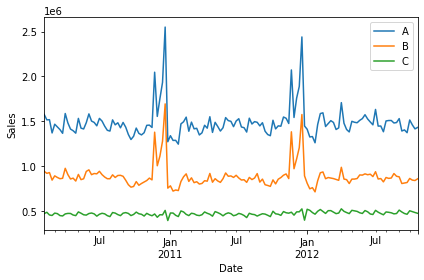

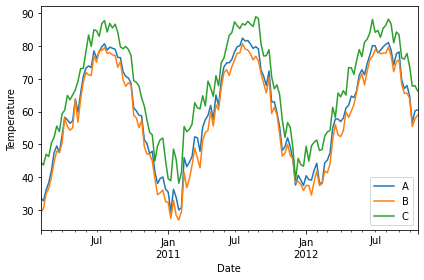

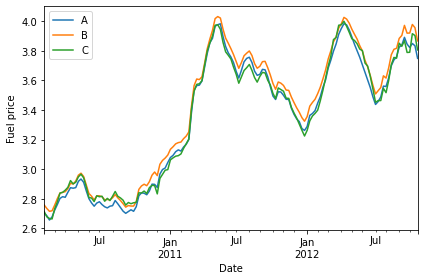

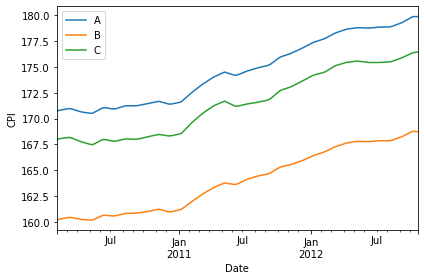

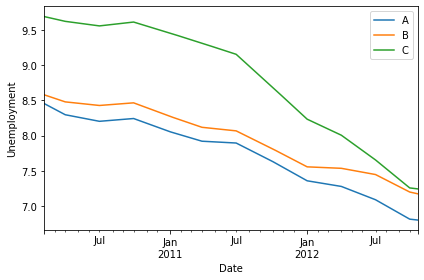

In [726]:
features = ['y', 'temperature', 'fuel_price', 'cpi', 'unemployment_interpolated']
plot_names = {'y':'Sales', 'temperature':'Temperature', 'fuel_price':'Fuel price', 'cpi':'CPI', 'unemployment_interpolated':'Unemployment'}
for f in features:
    ax = plt.subplot()
    for key in datasets.keys():
        datasets[key].plot(x='ds', y=f, ax=ax)
    ax.legend(datasets.keys())
    ax.set_ylabel(plot_names[f])
    ax.set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'plots/dataset_plot_{f}.eps', format='eps')
    plt.show()

In [138]:
features.diff(1)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,unemployment_interpolated
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,7 days,-3.80,-0.024,NaN,NaN,NaN,NaN,NaN,0.145812,0.0,True,-0.03725
2,0.0,7 days,1.42,-0.034,NaN,NaN,NaN,NaN,NaN,0.046973,0.0,True,-0.03725
3,0.0,7 days,6.70,0.047,NaN,NaN,NaN,NaN,NaN,0.030500,0.0,False,-0.03725
4,0.0,7 days,-0.13,0.064,NaN,NaN,NaN,NaN,NaN,0.030500,0.0,False,-0.03725
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,0.0,7 days,5.92,0.013,-147.05,589.72,-175.56,-13.45,51.75,NaN,NaN,False,0.00000
8186,0.0,7 days,1.45,-0.025,4248.19,1293.55,579.74,3347.50,-1654.76,NaN,NaN,False,0.00000
8187,0.0,7 days,1.87,0.000,-5300.54,-441.27,-497.02,-5052.63,635.43,NaN,NaN,False,0.00000
8188,0.0,7 days,3.47,0.123,-828.45,-780.24,118.47,-381.84,-1090.90,NaN,NaN,False,0.00000


In [ ]:
ax.set_ylabel()

In [672]:
datasets['A']

,ds,temperature,fuel_price,cpi,unemployment_interpolated,y,overfit
0,2010-02-05,33.690032,2.703840,170.722140,8.453469,1.576715e+06,0.618009
1,2010-02-12,32.856791,2.685976,170.819624,8.433678,1.516366e+06,0.593377
2,2010-02-19,36.120051,2.657191,170.866465,8.413886,1.518252e+06,0.594114
3,2010-02-26,38.431706,2.678402,170.904866,8.394094,1.370861e+06,0.538734
4,2010-03-05,42.054062,2.724567,170.943267,8.374303,1.468024e+06,0.572834
...,...,...,...,...,...,...,...
138,2012-09-28,67.947303,3.845498,179.599142,6.835551,1.373897e+06,0.540572
139,2012-10-05,64.778709,3.822979,179.737298,6.814390,1.515141e+06,0.591364
140,2012-10-12,56.607945,3.849897,179.875454,6.810223,1.460697e+06,0.571143
141,2012-10-19,60.217018,3.834338,179.892947,6.806056,1.416175e+06,0.555929


In [416]:
{metric:list(v.values())[0] for metric, v in res.items()}

{'aic': -384.8779188537933,
 'dic': -432.1390722343087,
 'waic': -7.837502984999105}

In [161]:
used_models = [m4]

In [21]:
used_models = [m1, m2, m3]

In [169]:
used_models = [m1, m2, m3, m4, m5]

In [3]:
used_models = get_clean_models()

Importing plotly failed. Interactive plots will not work.


In [84]:
big_output = metrics_refactored.fit_all(get_clean_models, dataset_generator())

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00:38:26 dset:aggregated_A, model:m1, metric:AIC
00:38:26 dset:aggregated_A, model:m1, metric:DIC
00:38:31 dset:aggregated_A, model:m1, metric:WAIC
00:38:31 dset:aggregated_A, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


00:40:55 dset:aggregated_A, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



00:42:20 dset:aggregated_A, model:m2, metric:AIC
00:42:20 dset:aggregated_A, model:m2, metric:DIC
00:42:26 dset:aggregated_A, model:m2, metric:WAIC
00:42:26 dset:aggregated_A, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


00:46:15 dset:aggregated_A, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



00:48:33 dset:aggregated_A, model:m3, metric:AIC
00:48:33 dset:aggregated_A, model:m3, metric:DIC
00:48:39 dset:aggregated_A, model:m3, metric:WAIC
00:48:39 dset:aggregated_A, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


00:54:53 dset:aggregated_A, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



00:57:37 dset:aggregated_A, model:m4, metric:AIC
00:57:37 dset:aggregated_A, model:m4, metric:DIC
00:57:43 dset:aggregated_A, model:m4, metric:WAIC
00:57:43 dset:aggregated_A, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:01:29 dset:aggregated_A, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:02:51 dset:aggregated_A, model:m5, metric:AIC
01:02:51 dset:aggregated_A, model:m5, metric:DIC
01:02:56 dset:aggregated_A, model:m5, metric:WAIC
01:02:56 dset:aggregated_A, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:03:26 dset:aggregated_A, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:04:02 dset:single_store_19_of_A, model:m1, metric:AIC
01:04:02 dset:single_store_19_of_A, model:m1, metric:DIC
01:04:09 dset:single_store_19_of_A, model:m1, metric:WAIC
01:04:09 dset:single_store_19_of_A, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:06:29 dset:single_store_19_of_A, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:07:54 dset:single_store_19_of_A, model:m2, metric:AIC
01:07:54 dset:single_store_19_of_A, model:m2, metric:DIC
01:07:59 dset:single_store_19_of_A, model:m2, metric:WAIC
01:07:59 dset:single_store_19_of_A, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:11:42 dset:single_store_19_of_A, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:13:52 dset:single_store_19_of_A, model:m3, metric:AIC
01:13:52 dset:single_store_19_of_A, model:m3, metric:DIC
01:13:58 dset:single_store_19_of_A, model:m3, metric:WAIC
01:13:58 dset:single_store_19_of_A, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:20:14 dset:single_store_19_of_A, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:22:57 dset:single_store_19_of_A, model:m4, metric:AIC
01:22:57 dset:single_store_19_of_A, model:m4, metric:DIC
01:23:03 dset:single_store_19_of_A, model:m4, metric:WAIC
01:23:03 dset:single_store_19_of_A, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:26:48 dset:single_store_19_of_A, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:28:10 dset:single_store_19_of_A, model:m5, metric:AIC
01:28:10 dset:single_store_19_of_A, model:m5, metric:DIC
01:28:15 dset:single_store_19_of_A, model:m5, metric:WAIC
01:28:15 dset:single_store_19_of_A, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:28:42 dset:single_store_19_of_A, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:29:15 dset:single_store_4_of_A, model:m1, metric:AIC
01:29:15 dset:single_store_4_of_A, model:m1, metric:DIC
01:29:20 dset:single_store_4_of_A, model:m1, metric:WAIC
01:29:20 dset:single_store_4_of_A, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:31:39 dset:single_store_4_of_A, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:33:11 dset:single_store_4_of_A, model:m2, metric:AIC
01:33:11 dset:single_store_4_of_A, model:m2, metric:DIC
01:33:16 dset:single_store_4_of_A, model:m2, metric:WAIC
01:33:16 dset:single_store_4_of_A, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:38:48 dset:single_store_4_of_A, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:41:48 dset:single_store_4_of_A, model:m3, metric:AIC
01:41:48 dset:single_store_4_of_A, model:m3, metric:DIC
01:41:54 dset:single_store_4_of_A, model:m3, metric:WAIC
01:41:54 dset:single_store_4_of_A, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:47:44 dset:single_store_4_of_A, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:50:19 dset:single_store_4_of_A, model:m4, metric:AIC
01:50:19 dset:single_store_4_of_A, model:m4, metric:DIC
01:50:25 dset:single_store_4_of_A, model:m4, metric:WAIC
01:50:25 dset:single_store_4_of_A, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:54:12 dset:single_store_4_of_A, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:55:34 dset:single_store_4_of_A, model:m5, metric:AIC
01:55:34 dset:single_store_4_of_A, model:m5, metric:DIC
01:55:38 dset:single_store_4_of_A, model:m5, metric:WAIC
01:55:38 dset:single_store_4_of_A, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:56:07 dset:single_store_4_of_A, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



01:56:40 dset:single_store_32_of_A, model:m1, metric:AIC
01:56:40 dset:single_store_32_of_A, model:m1, metric:DIC
01:56:46 dset:single_store_32_of_A, model:m1, metric:WAIC
01:56:46 dset:single_store_32_of_A, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


01:59:01 dset:single_store_32_of_A, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:00:22 dset:single_store_32_of_A, model:m2, metric:AIC
02:00:22 dset:single_store_32_of_A, model:m2, metric:DIC
02:00:27 dset:single_store_32_of_A, model:m2, metric:WAIC
02:00:27 dset:single_store_32_of_A, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:03:59 dset:single_store_32_of_A, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:06:02 dset:single_store_32_of_A, model:m3, metric:AIC
02:06:02 dset:single_store_32_of_A, model:m3, metric:DIC
02:06:07 dset:single_store_32_of_A, model:m3, metric:WAIC
02:06:07 dset:single_store_32_of_A, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:11:59 dset:single_store_32_of_A, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:14:32 dset:single_store_32_of_A, model:m4, metric:AIC
02:14:32 dset:single_store_32_of_A, model:m4, metric:DIC
02:14:38 dset:single_store_32_of_A, model:m4, metric:WAIC
02:14:38 dset:single_store_32_of_A, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:18:13 dset:single_store_32_of_A, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:19:35 dset:single_store_32_of_A, model:m5, metric:AIC
02:19:35 dset:single_store_32_of_A, model:m5, metric:DIC
02:19:39 dset:single_store_32_of_A, model:m5, metric:WAIC
02:19:39 dset:single_store_32_of_A, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:20:08 dset:single_store_32_of_A, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:20:42 dset:aggregated_B, model:m1, metric:AIC
02:20:42 dset:aggregated_B, model:m1, metric:DIC
02:20:47 dset:aggregated_B, model:m1, metric:WAIC
02:20:47 dset:aggregated_B, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:22:59 dset:aggregated_B, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:24:14 dset:aggregated_B, model:m2, metric:AIC
02:24:14 dset:aggregated_B, model:m2, metric:DIC
02:24:19 dset:aggregated_B, model:m2, metric:WAIC
02:24:19 dset:aggregated_B, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:27:29 dset:aggregated_B, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:29:24 dset:aggregated_B, model:m3, metric:AIC
02:29:24 dset:aggregated_B, model:m3, metric:DIC
02:29:29 dset:aggregated_B, model:m3, metric:WAIC
02:29:29 dset:aggregated_B, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:35:20 dset:aggregated_B, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:37:49 dset:aggregated_B, model:m4, metric:AIC
02:37:49 dset:aggregated_B, model:m4, metric:DIC
02:37:55 dset:aggregated_B, model:m4, metric:WAIC
02:37:55 dset:aggregated_B, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:41:20 dset:aggregated_B, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:42:37 dset:aggregated_B, model:m5, metric:AIC
02:42:37 dset:aggregated_B, model:m5, metric:DIC
02:42:41 dset:aggregated_B, model:m5, metric:WAIC
02:42:41 dset:aggregated_B, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:43:08 dset:aggregated_B, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:43:39 dset:single_store_7_of_B, model:m1, metric:AIC
02:43:39 dset:single_store_7_of_B, model:m1, metric:DIC
02:43:45 dset:single_store_7_of_B, model:m1, metric:WAIC
02:43:45 dset:single_store_7_of_B, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:45:55 dset:single_store_7_of_B, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:47:13 dset:single_store_7_of_B, model:m2, metric:AIC
02:47:13 dset:single_store_7_of_B, model:m2, metric:DIC
02:47:18 dset:single_store_7_of_B, model:m2, metric:WAIC
02:47:18 dset:single_store_7_of_B, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:50:46 dset:single_store_7_of_B, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



02:52:44 dset:single_store_7_of_B, model:m3, metric:AIC
02:52:44 dset:single_store_7_of_B, model:m3, metric:DIC
02:52:49 dset:single_store_7_of_B, model:m3, metric:WAIC
02:52:49 dset:single_store_7_of_B, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


02:58:36 dset:single_store_7_of_B, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:01:11 dset:single_store_7_of_B, model:m4, metric:AIC
03:01:11 dset:single_store_7_of_B, model:m4, metric:DIC
03:01:17 dset:single_store_7_of_B, model:m4, metric:WAIC
03:01:17 dset:single_store_7_of_B, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:04:24 dset:single_store_7_of_B, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:05:41 dset:single_store_7_of_B, model:m5, metric:AIC
03:05:41 dset:single_store_7_of_B, model:m5, metric:DIC
03:05:45 dset:single_store_7_of_B, model:m5, metric:WAIC
03:05:45 dset:single_store_7_of_B, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:06:09 dset:single_store_7_of_B, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:06:40 dset:single_store_23_of_B, model:m1, metric:AIC
03:06:40 dset:single_store_23_of_B, model:m1, metric:DIC
03:06:45 dset:single_store_23_of_B, model:m1, metric:WAIC
03:06:45 dset:single_store_23_of_B, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:08:56 dset:single_store_23_of_B, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:10:15 dset:single_store_23_of_B, model:m2, metric:AIC
03:10:15 dset:single_store_23_of_B, model:m2, metric:DIC
03:10:20 dset:single_store_23_of_B, model:m2, metric:WAIC
03:10:20 dset:single_store_23_of_B, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:13:53 dset:single_store_23_of_B, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:16:06 dset:single_store_23_of_B, model:m3, metric:AIC
03:16:06 dset:single_store_23_of_B, model:m3, metric:DIC
03:16:12 dset:single_store_23_of_B, model:m3, metric:WAIC
03:16:12 dset:single_store_23_of_B, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:21:57 dset:single_store_23_of_B, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:24:25 dset:single_store_23_of_B, model:m4, metric:AIC
03:24:25 dset:single_store_23_of_B, model:m4, metric:DIC
03:24:31 dset:single_store_23_of_B, model:m4, metric:WAIC
03:24:31 dset:single_store_23_of_B, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:27:36 dset:single_store_23_of_B, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:28:52 dset:single_store_23_of_B, model:m5, metric:AIC
03:28:52 dset:single_store_23_of_B, model:m5, metric:DIC
03:28:56 dset:single_store_23_of_B, model:m5, metric:WAIC
03:28:56 dset:single_store_23_of_B, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:29:21 dset:single_store_23_of_B, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:29:51 dset:single_store_17_of_B, model:m1, metric:AIC
03:29:51 dset:single_store_17_of_B, model:m1, metric:DIC
03:29:56 dset:single_store_17_of_B, model:m1, metric:WAIC
03:29:57 dset:single_store_17_of_B, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:31:57 dset:single_store_17_of_B, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:33:06 dset:single_store_17_of_B, model:m2, metric:AIC
03:33:06 dset:single_store_17_of_B, model:m2, metric:DIC
03:33:12 dset:single_store_17_of_B, model:m2, metric:WAIC
03:33:12 dset:single_store_17_of_B, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:35:51 dset:single_store_17_of_B, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:37:35 dset:single_store_17_of_B, model:m3, metric:AIC
03:37:35 dset:single_store_17_of_B, model:m3, metric:DIC
03:37:40 dset:single_store_17_of_B, model:m3, metric:WAIC
03:37:40 dset:single_store_17_of_B, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:43:17 dset:single_store_17_of_B, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:45:35 dset:single_store_17_of_B, model:m4, metric:AIC
03:45:35 dset:single_store_17_of_B, model:m4, metric:DIC
03:45:41 dset:single_store_17_of_B, model:m4, metric:WAIC
03:45:41 dset:single_store_17_of_B, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:48:22 dset:single_store_17_of_B, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:49:30 dset:single_store_17_of_B, model:m5, metric:AIC
03:49:30 dset:single_store_17_of_B, model:m5, metric:DIC
03:49:35 dset:single_store_17_of_B, model:m5, metric:WAIC
03:49:35 dset:single_store_17_of_B, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:50:04 dset:single_store_17_of_B, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:50:41 dset:aggregated_C, model:m1, metric:AIC
03:50:41 dset:aggregated_C, model:m1, metric:DIC
03:50:46 dset:aggregated_C, model:m1, metric:WAIC
03:50:46 dset:aggregated_C, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:53:31 dset:aggregated_C, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



03:55:04 dset:aggregated_C, model:m2, metric:AIC
03:55:04 dset:aggregated_C, model:m2, metric:DIC
03:55:09 dset:aggregated_C, model:m2, metric:WAIC
03:55:09 dset:aggregated_C, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


03:59:10 dset:aggregated_C, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:01:26 dset:aggregated_C, model:m3, metric:AIC
04:01:26 dset:aggregated_C, model:m3, metric:DIC
04:01:32 dset:aggregated_C, model:m3, metric:WAIC
04:01:32 dset:aggregated_C, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:08:01 dset:aggregated_C, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:10:59 dset:aggregated_C, model:m4, metric:AIC
04:10:59 dset:aggregated_C, model:m4, metric:DIC
04:11:04 dset:aggregated_C, model:m4, metric:WAIC
04:11:04 dset:aggregated_C, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:16:33 dset:aggregated_C, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:18:26 dset:aggregated_C, model:m5, metric:AIC
04:18:26 dset:aggregated_C, model:m5, metric:DIC
04:18:31 dset:aggregated_C, model:m5, metric:WAIC
04:18:31 dset:aggregated_C, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:19:21 dset:aggregated_C, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:20:07 dset:single_store_44_of_C, model:m1, metric:AIC
04:20:07 dset:single_store_44_of_C, model:m1, metric:DIC
04:20:13 dset:single_store_44_of_C, model:m1, metric:WAIC
04:20:13 dset:single_store_44_of_C, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:22:57 dset:single_store_44_of_C, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:24:38 dset:single_store_44_of_C, model:m2, metric:AIC
04:24:38 dset:single_store_44_of_C, model:m2, metric:DIC
04:24:44 dset:single_store_44_of_C, model:m2, metric:WAIC
04:24:44 dset:single_store_44_of_C, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:30:03 dset:single_store_44_of_C, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:32:41 dset:single_store_44_of_C, model:m3, metric:AIC
04:32:41 dset:single_store_44_of_C, model:m3, metric:DIC
04:32:47 dset:single_store_44_of_C, model:m3, metric:WAIC
04:32:47 dset:single_store_44_of_C, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:38:56 dset:single_store_44_of_C, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:41:45 dset:single_store_44_of_C, model:m4, metric:AIC
04:41:45 dset:single_store_44_of_C, model:m4, metric:DIC
04:41:50 dset:single_store_44_of_C, model:m4, metric:WAIC
04:41:50 dset:single_store_44_of_C, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:45:40 dset:single_store_44_of_C, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:47:07 dset:single_store_44_of_C, model:m5, metric:AIC
04:47:07 dset:single_store_44_of_C, model:m5, metric:DIC
04:47:12 dset:single_store_44_of_C, model:m5, metric:WAIC
04:47:12 dset:single_store_44_of_C, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:47:57 dset:single_store_44_of_C, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:48:44 dset:single_store_37_of_C, model:m1, metric:AIC
04:48:44 dset:single_store_37_of_C, model:m1, metric:DIC
04:48:49 dset:single_store_37_of_C, model:m1, metric:WAIC
04:48:50 dset:single_store_37_of_C, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:52:10 dset:single_store_37_of_C, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



04:54:00 dset:single_store_37_of_C, model:m2, metric:AIC
04:54:00 dset:single_store_37_of_C, model:m2, metric:DIC
04:54:06 dset:single_store_37_of_C, model:m2, metric:WAIC
04:54:06 dset:single_store_37_of_C, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


04:58:36 dset:single_store_37_of_C, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:01:03 dset:single_store_37_of_C, model:m3, metric:AIC
05:01:03 dset:single_store_37_of_C, model:m3, metric:DIC
05:01:09 dset:single_store_37_of_C, model:m3, metric:WAIC
05:01:09 dset:single_store_37_of_C, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:08:05 dset:single_store_37_of_C, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:11:16 dset:single_store_37_of_C, model:m4, metric:AIC
05:11:16 dset:single_store_37_of_C, model:m4, metric:DIC
05:11:21 dset:single_store_37_of_C, model:m4, metric:WAIC
05:11:21 dset:single_store_37_of_C, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:16:21 dset:single_store_37_of_C, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:18:14 dset:single_store_37_of_C, model:m5, metric:AIC
05:18:14 dset:single_store_37_of_C, model:m5, metric:DIC
05:18:19 dset:single_store_37_of_C, model:m5, metric:WAIC
05:18:19 dset:single_store_37_of_C, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:19:09 dset:single_store_37_of_C, model:m5, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:19:52 dset:single_store_38_of_C, model:m1, metric:AIC
05:19:52 dset:single_store_38_of_C, model:m1, metric:DIC
05:19:57 dset:single_store_38_of_C, model:m1, metric:WAIC
05:19:57 dset:single_store_38_of_C, model:m1, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:22:11 dset:single_store_38_of_C, model:m1, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:23:29 dset:single_store_38_of_C, model:m2, metric:AIC
05:23:29 dset:single_store_38_of_C, model:m2, metric:DIC
05:23:35 dset:single_store_38_of_C, model:m2, metric:WAIC
05:23:35 dset:single_store_38_of_C, model:m2, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:26:34 dset:single_store_38_of_C, model:m2, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:28:29 dset:single_store_38_of_C, model:m3, metric:AIC
05:28:29 dset:single_store_38_of_C, model:m3, metric:DIC
05:28:35 dset:single_store_38_of_C, model:m3, metric:WAIC
05:28:35 dset:single_store_38_of_C, model:m3, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:34:38 dset:single_store_38_of_C, model:m3, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:37:16 dset:single_store_38_of_C, model:m4, metric:AIC
05:37:16 dset:single_store_38_of_C, model:m4, metric:DIC
05:37:22 dset:single_store_38_of_C, model:m4, metric:WAIC
05:37:22 dset:single_store_38_of_C, model:m4, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:40:40 dset:single_store_38_of_C, model:m4, metric:default_cv


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



05:42:04 dset:single_store_38_of_C, model:m5, metric:AIC
05:42:04 dset:single_store_38_of_C, model:m5, metric:DIC
05:42:09 dset:single_store_38_of_C, model:m5, metric:WAIC
05:42:09 dset:single_store_38_of_C, model:m5, metric:10-fold_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


05:42:46 dset:single_store_38_of_C, model:m5, metric:default_cv


In [86]:
big_output[0].head(30)

,metric_name,value,dataset_name,model_name,aux
0,AIC,-394.399,aggregated_A,m1,None
1,DIC,-438.828,aggregated_A,m1,{'p_dic': 24.691509379706474}
2,WAIC,-15.9012,aggregated_A,m1,{'p_waic': 236.24901258297655}
3,10-fold_cv,205.388,aggregated_A,m1,"{'lppd_loo_cv': 202.6521732975443, 'bias': 2.7..."
4,default_cv,horizon mse rmse ...,aggregated_A,m1,ds yhat yhat_lower y...
5,AIC,-384.562,aggregated_A,m2,None
6,DIC,-431.473,aggregated_A,m2,{'p_dic': 29.154431766886603}
7,WAIC,136.516,aggregated_A,m2,{'p_waic': 312.5386520410656}
8,10-fold_cv,208.157,aggregated_A,m2,"{'lppd_loo_cv': 205.40438079752116, 'bias': 2...."
9,default_cv,horizon mse rmse ...,aggregated_A,m2,ds yhat yhat_lower y...


In [90]:
f = big_output[0].copy()

In [104]:
f[mask]['value'].apply(lambda x: x['mape']).values.reshape(-1)

(60,)

In [105]:
mask = f['metric_name']=='default_cv'
f.loc[mask, 'value'] = f[mask]['value'].apply(lambda x: x['mape']).values.reshape(-1)

In [108]:
f.to_csv('big_fit.csv')

In [130]:
import json
from prophet.python.fbprophet.serialize import model_to_json, model_from_json

In [131]:
models_to_json = big_output[1].copy()

In [135]:
models_to_json['model'] = models_to_json['model'].apply(model_to_json)

In [136]:
models_to_json.to_pickle('all_fitted_models.pkl')

In [109]:
for dset_name, chunk in f.groupby('dataset_name'):
    print(f'\n{dset_name}\n')
    pivoted = chunk.pivot(index='model_name', columns='metric_name', values='value')
    print(pivoted)
    pivoted.to_csv(f'{dset_name}_metrics.csv')
    


aggregated_A

metric_name 10-fold_cv      AIC      DIC     WAIC default_cv
model_name                                                  
m1             205.388 -394.399 -438.828 -15.9012  0.0336421
m2             208.157 -384.562 -431.473  136.516  0.0445197
m3             349.562  -654.49   -702.1 -669.252  0.0219278
m4             164.059 -457.358 -512.371 -41.6151  0.0275329
m5             351.273 -703.916 -703.163 -707.849  0.0252841

aggregated_B

metric_name 10-fold_cv      AIC      DIC     WAIC default_cv
model_name                                                  
m1             204.185  -374.31 -419.052  19.2987  0.0279464
m2             196.886 -365.502 -412.157  315.892  0.0494179
m3             347.317 -647.787 -695.265 -663.161   0.025492
m4             162.142 -446.907 -501.358  152.229  0.0286346
m5             348.932 -699.396  -698.27 -701.503   0.029721

aggregated_C

metric_name 10-fold_cv      AIC      DIC     WAIC default_cv
model_name                              

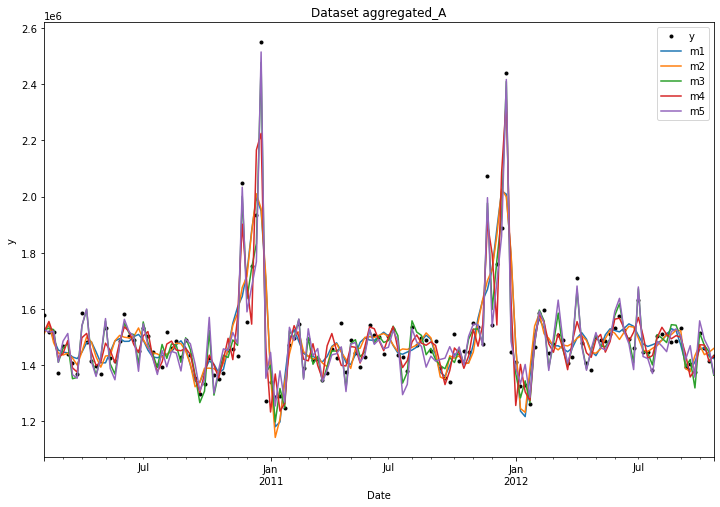

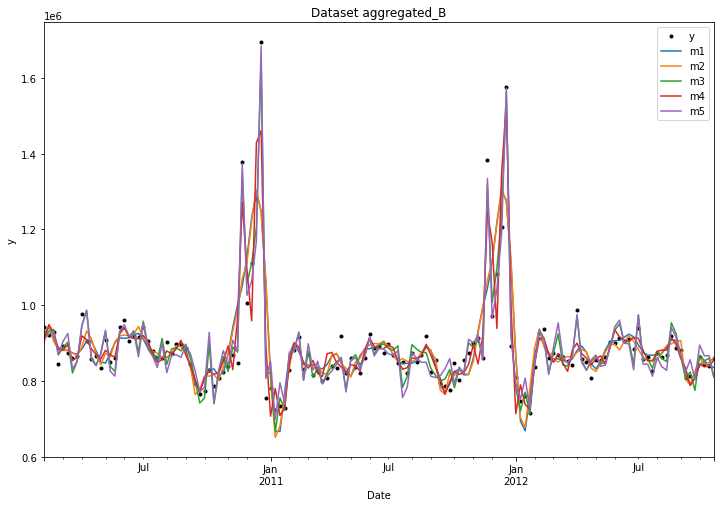

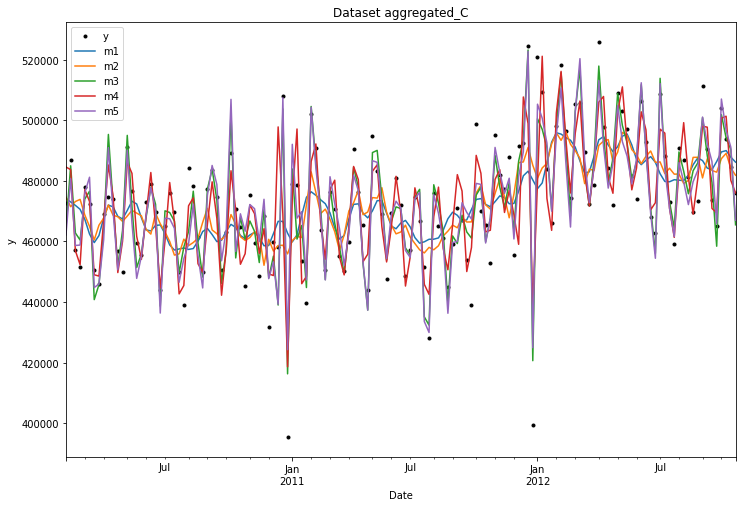

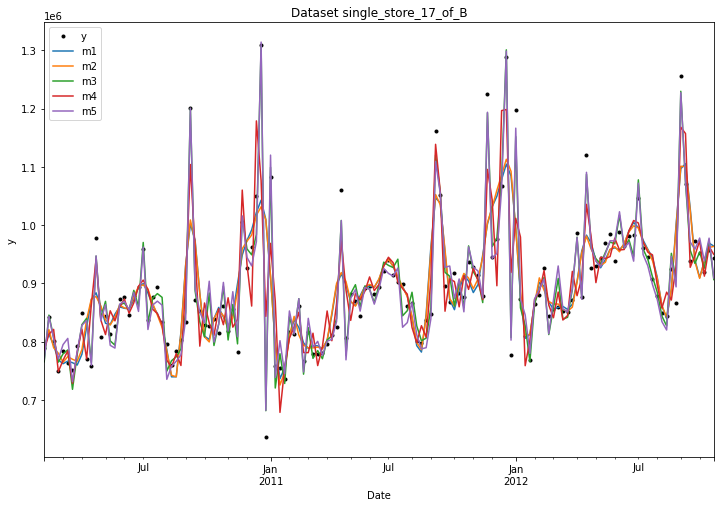

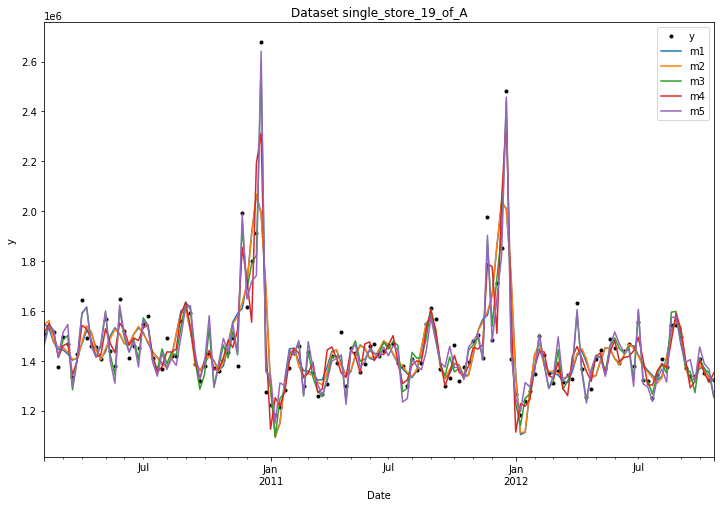

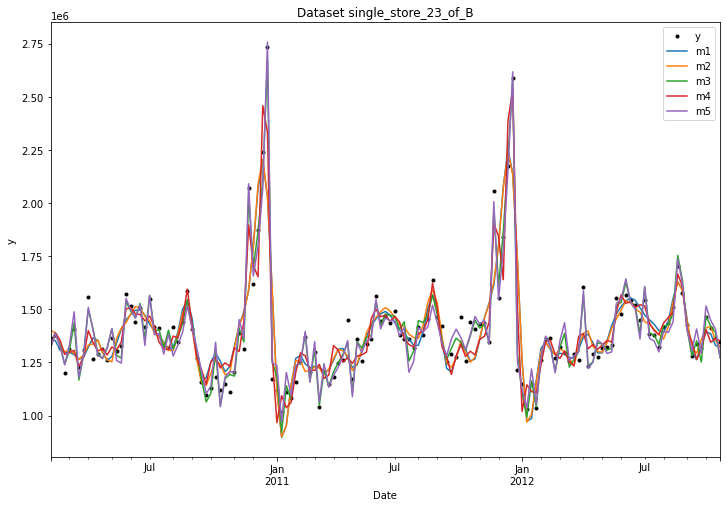

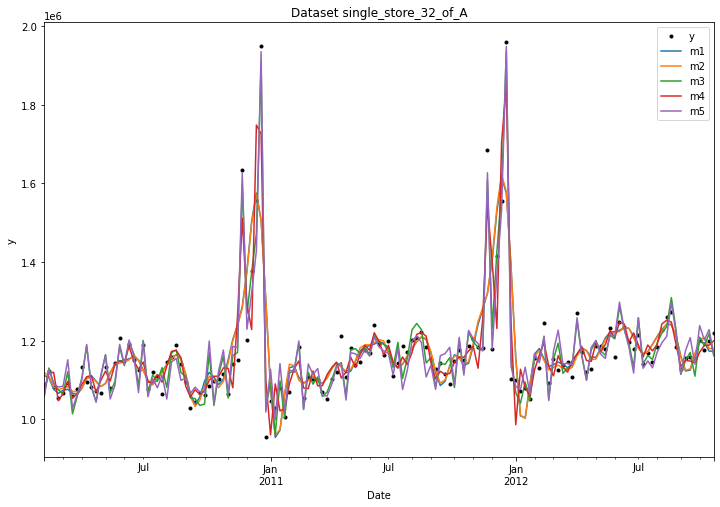

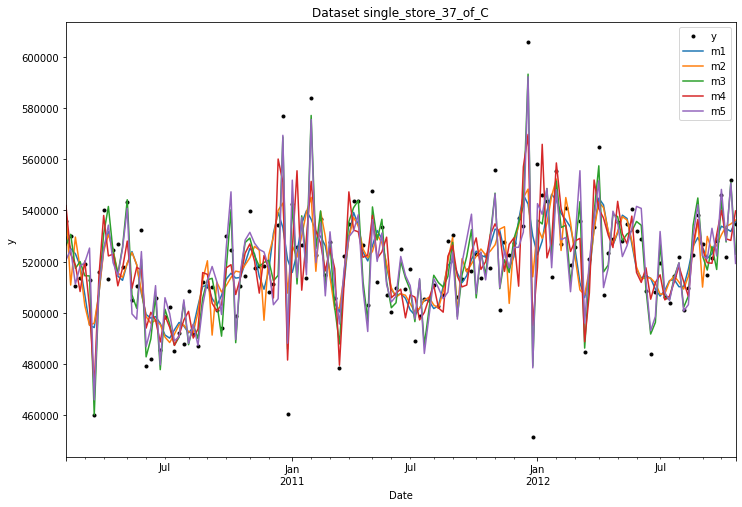

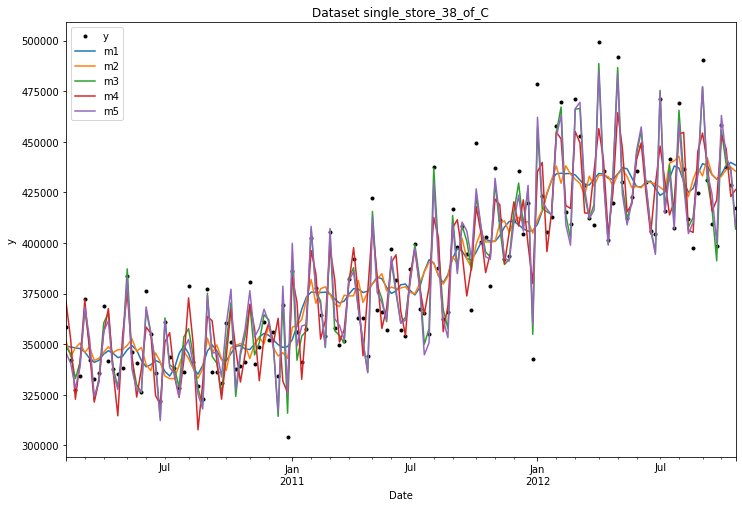

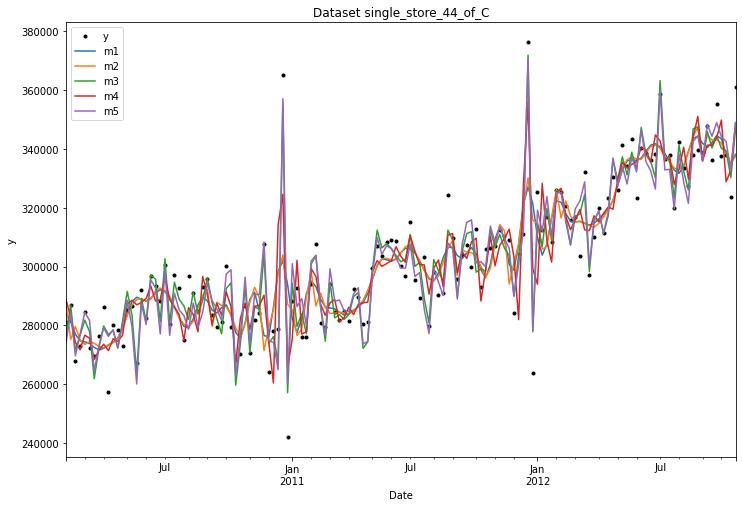

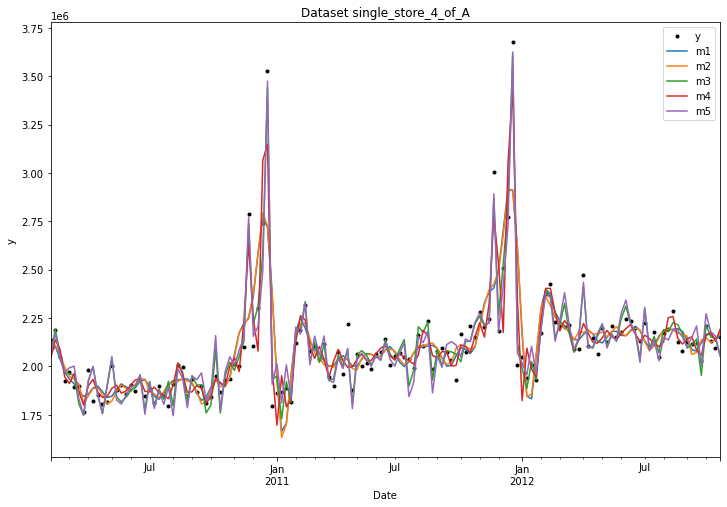

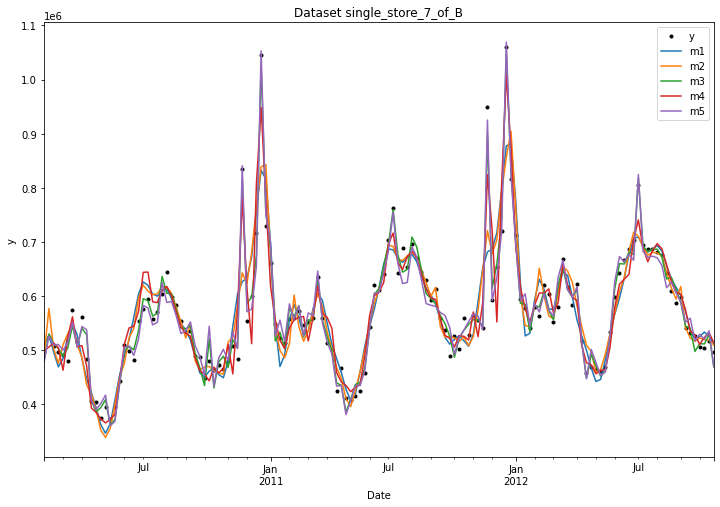

In [127]:
#dset = 'aggregated_A'

#chunk = big_output[1][big_output[1]['dataset_name']==dset]

for dset_name, chunk in big_output[1].groupby('dataset_name'):
    fig, ax = plt.subplots(figsize=(12, 8))
    chunk.iloc[0,0].history.plot(x='ds', y='y', style='k.', ax=ax)
    for _, row in chunk.iterrows():
        pred = row['model'].predict()
        pred.plot(ax=ax, x='ds', y='yhat', label=row['model_name'])
    ax.set_ylabel('y')
    ax.set_xlabel('Date')
    ax.set_title(f'Dataset {dset_name}');

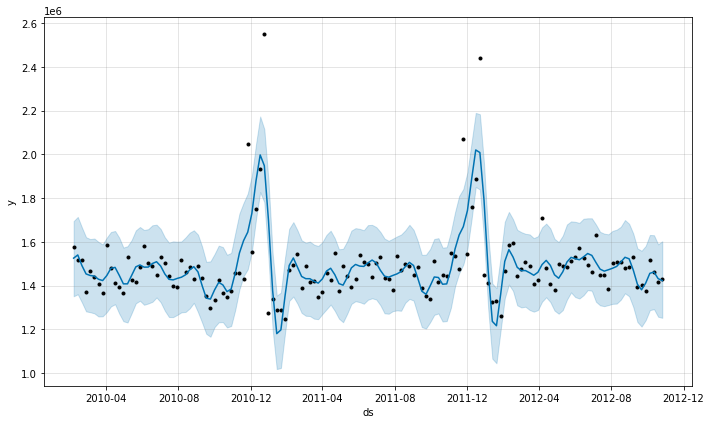

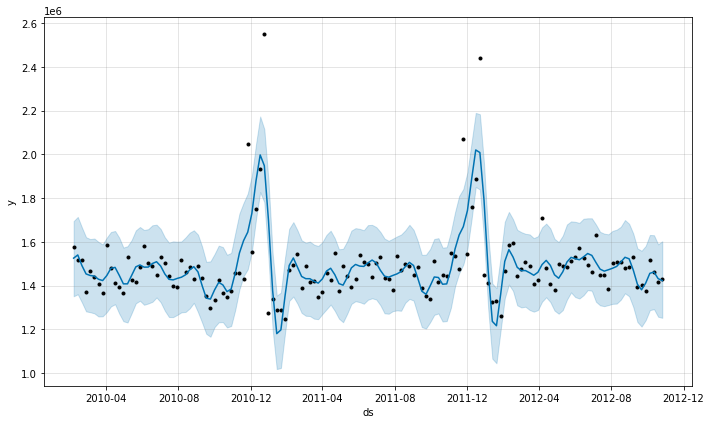

In [112]:
big_output[1].iloc[0,0].plot(big_output[1].iloc[0,0].predict())

In [15]:
%time
res = metrics.compare_models(used_models[:2], format_for_prophet(data[data['Store']==1]))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluating AIC
-383.85539006684303
-375.21659036503013

Evaluating DIC
-430.944122407198
-425.6987900546624

Evaluating WAIC2
-256.57394970981335
-170.01344921067567

Evaluating p_dic
24.80453335940041
28.47135495521775

Evaluating p_dic_alt
31.993728798528988
33.696108769467706

Evaluating p_waic2
110.64072017851484
154.60157057717723

Evaluating 10-fold_cv
Done


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00


Done

Evaluating default_cv


INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-06 12:00:00 and 2012-07-13 00:00:00



Done



Done



In [24]:
list(res['default_cv'].values())[0]['aggregated']

,horizon,mse,rmse,mae,mape,mdape,coverage
0,105 days,1.018629e+10,100927.145475,79223.570131,0.04913,0.044978,0.95


In [26]:
from prophet.python.fbprophet import plot as fbplot

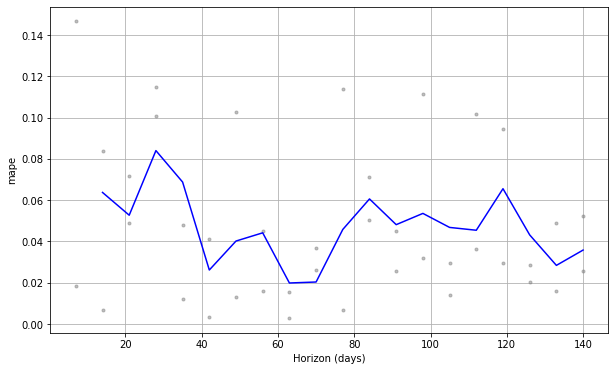

In [28]:
fbplot.plot_cross_validation_metric(cv_res, 'mape');

In [33]:
diagnostics.performance_metrics(cv_res, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,140 days,9.515632e+09,97548.102728,75600.843259,0.047712,0.036667,0.925


In [211]:
m5_test.params['beta'].mean(axis=0)

array([0.99969518])

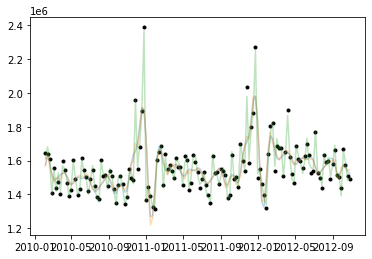

In [770]:
ax = plt.subplot()
#ax2 = plt.subplot()
t = used_models[0].history['ds'].dt.to_pydatetime()
ax.plot(t, used_models[0].history['y'], 'k.')
for m in used_models:
    fc = m.predict()
    ax.plot(t, fc['yhat'], ls='-', alpha=0.3)

<AxesSubplot:xlabel='ds'>

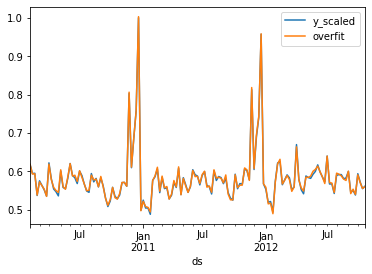

In [740]:

ax = m1.history.plot(x='ds', y='y_scaled')
m5_test.history.plot(x='ds', y='overfit', ax=ax)

In [173]:
m5.history['y_scaled'].mean()

0.5828448647174851

In [174]:
m5.history['overfit'].mean()

0.5876918005062771

In [194]:
(m5.history['overfit'] - m5.history['y_scaled']).mean()

0.0048469357887920925

In [204]:
(m5.params['m'][:, np.newaxis] / m5.history['y_scaled'].values[np.newaxis, :]).mean()

0.09185084611800698

In [181]:
res = compare_models([m1, m2], format_for_prophet(data[data['Store']==2]), no_fit=True, metrics = {'10-fold-cv':lambda x: k_fold_loo_cv(x, k=10)})

Evaluating 10-fold-cv
Done
Done



In [253]:
result_df = pd.DataFrame(index=used_models)

In [254]:
for metric_name, values in res_A.items():
    for model, value in values.items():
        if type(value) == dict:
            cols = [c for c in value.keys() if c != 'fitted_params']
            for c in cols:
                result_df.loc[model, f'{metric_name}_{c}'] = value[c]
        else:
            result_df.loc[model, metric_name] = value
result_df = result_df.rename(index={m1:'m1', m2:'m2', m3:'m3', m4:'m4', m5:'m5'})

In [255]:
result_df

,aic,dic,waic,10-fold-cv_lppd_loo_cv,10-fold-cv_lppd_cloo_cv,10-fold-cv_bias,10-fold-cv_p_cloo
m1,-393.273233,-438.295551,-47.288752,211.248997,213.860186,2.611189,29.776430
m2,-386.108843,-433.483779,-5.772069,206.478646,208.540084,2.061438,35.514337
m3,-594.846456,-641.922596,-575.860533,306.996194,311.499716,4.503522,33.923512
m4,-456.019854,-511.907067,-31.473996,141.942643,151.167944,9.225301,143.841983
m5,-650.773633,-649.487336,-649.512305,323.798699,324.968025,1.169326,4.418791


In [265]:
import arviz

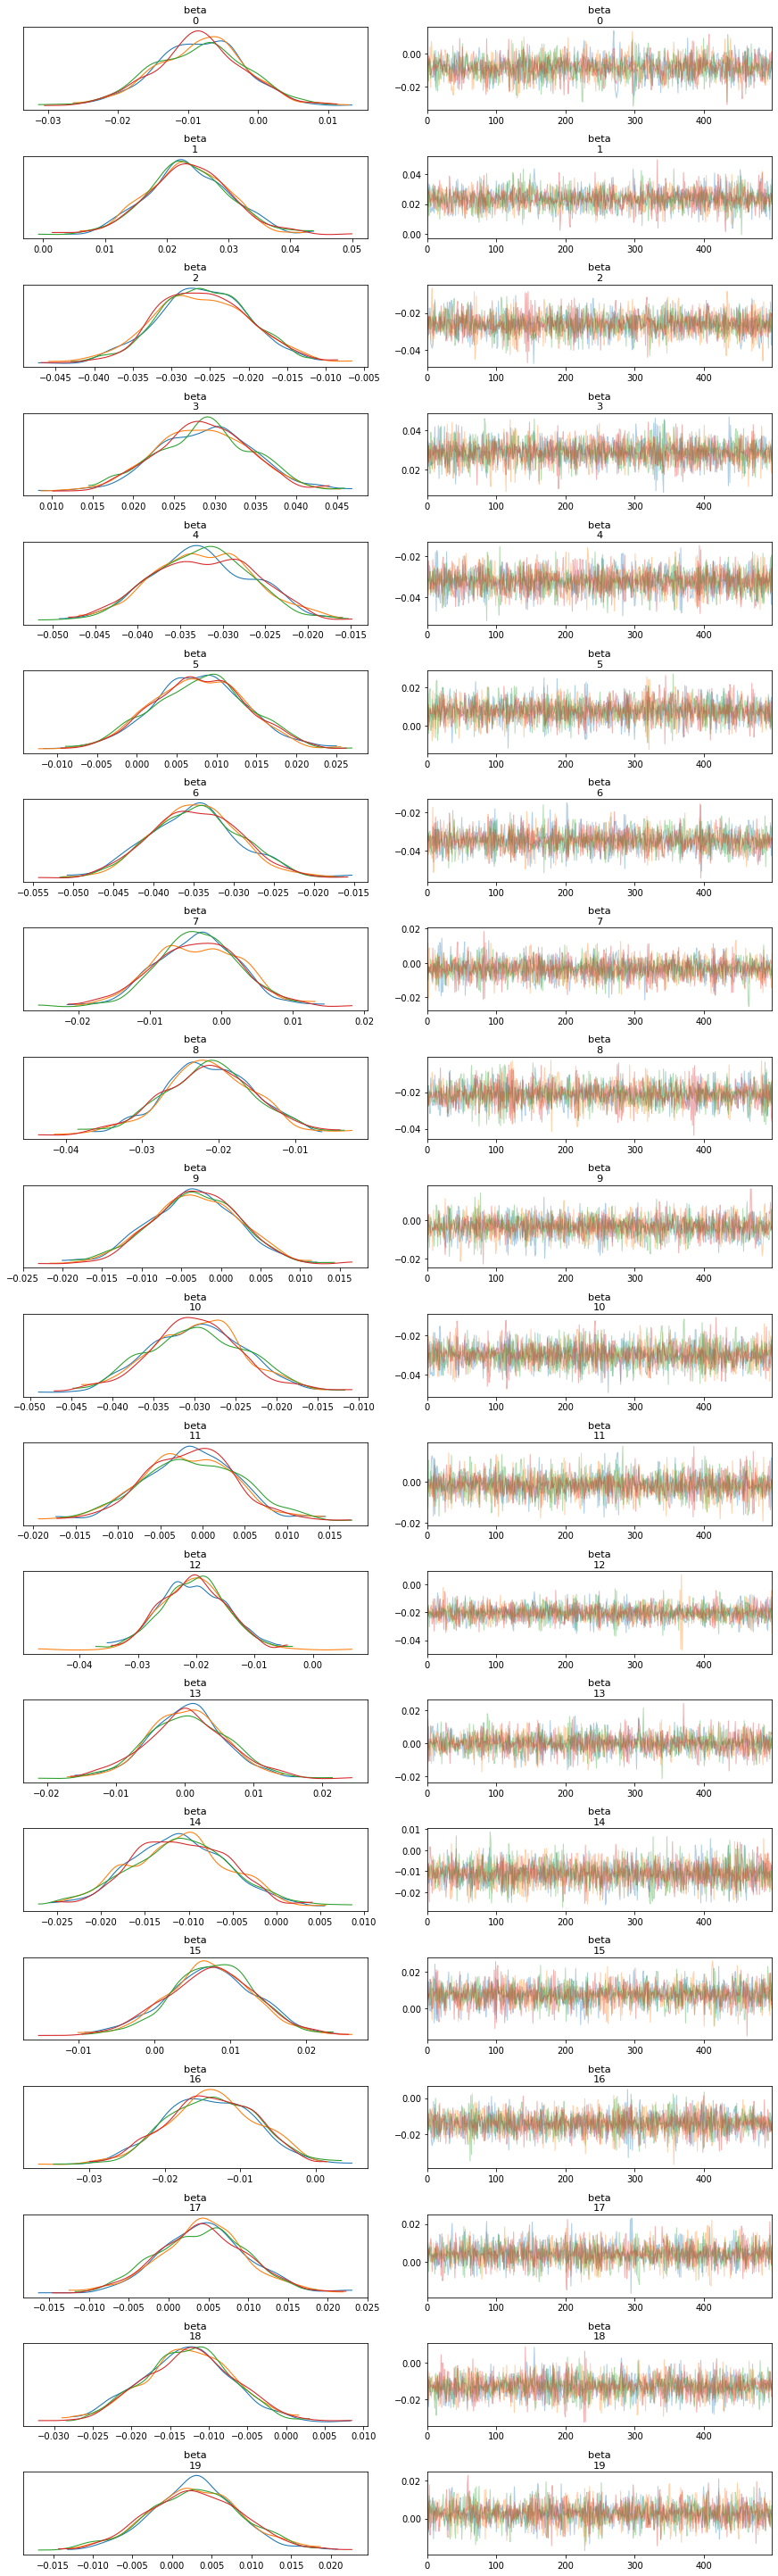

In [268]:
arviz.plot_trace(m1.stan_backend.stan_fit, var_names='beta');

In [314]:
kmean = m5.params['k'].mean()
mmean = m5.params['m'].mean()
deltamean = m5.params['delta'].mean()
sigmamean = m5.params['sigma_obs'].mean()
betamean = m5.params['beta'].mean()

In [357]:
d = 0.1
xvals = np.linspace(betamean - d + 0.1, betamean + d + 0.1, num=40)
yvals = np.linspace(mmean - d, mmean + d, num=40)

In [358]:
values = pd.concat([pd.Series({'x': x, 'y':y, 'value':m5.stan_backend.stan_fit.log_prob(upar=[kmean, y, deltamean, sigmamean, x])}) for x in xvals for y in yvals], axis=1).T

<AxesSubplot:xlabel='y', ylabel='x'>

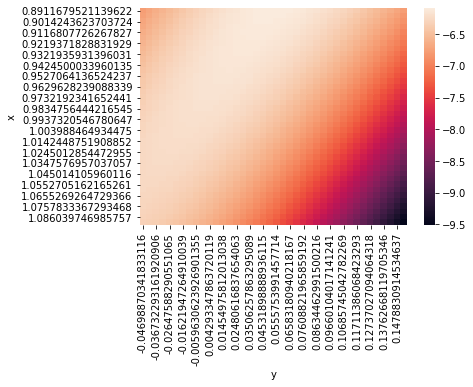

In [359]:
sns.heatmap(values.pivot(index='x', columns='y', values='value'))

In [285]:
m5.stan_backend.stan_fit.log_prob(upar=[0, 0, 0, 0.03, 1])

-6.9292482250305385

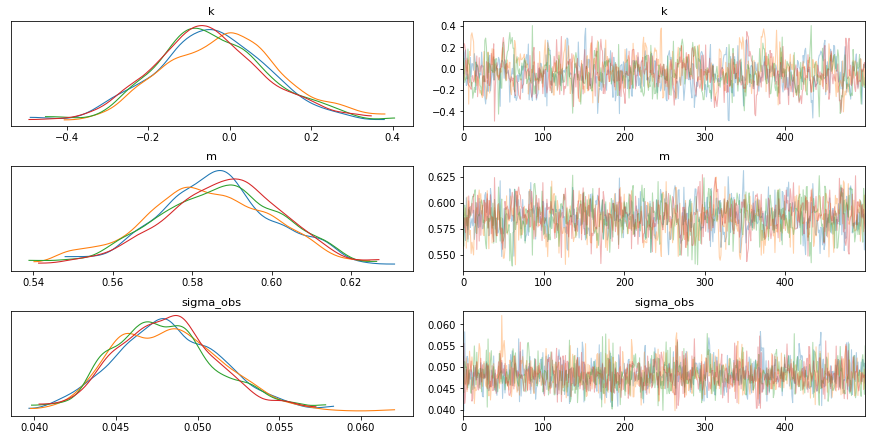

In [116]:
arviz.plot_trace(m1.stan_backend.stan_fit, var_names=['k', 'm', 'sigma_obs']);